In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

def plot_histogram(data,numberofbins,label,minimum,maximum):
    bins = np.linspace(minimum, maximum, numberofbins)
    bin_probabilities = np.histogram(data,bins)[0]/len(data)
    leftedges = bins[:-1]
    rightedges = bins[1:]
    widths = np.array(rightedges)-np.array(leftedges)
    plt.bar(leftedges,bin_probabilities,width=widths,align='edge',label=label,alpha=0.5)
    binmidvalues = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

In [2]:
class Person(object):
    def __init__(self,starting_x,starting_y,walk_method,min_x,max_x,min_y,max_y):
        self.status = 0 #0 = Health, 1 = Infected, 2 = Immune
        self.x = starting_x
        self.y = starting_y
        self.days_ill = 0
        self.walk_method = walk_method #'Random_single_walk','Sick_become_stationary'
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
    def get_position(self):
        return [self.x,self.y]
    def get_status(self):
        return self.status
    def get_days_ill(self):
        return self.days_ill
    def infect_self(self):
        if self.status == 0:
            self.status = 1
    def perform_walk(self):
        if self.walk_method == 'Random_single_walk':
            thingtodo = np.random.randint(0,5)
            if thingtodo == 1:# Walk left
                self.x = max(self.min_x,self.x - 1)
            elif thingtodo == 2:# Walk right
                self.x = min(self.max_x,self.x+1)
            elif thingtodo == 3:# Walk up
                self.y = min(self.max_y,self.y+1)
            elif thingtodo == 4:# Walk down
                self.y = max(self.min_y,self.y-1)
        elif self.walk_method == 'Sick_become_stationary':
            if self.status != 1:#If not sick, then can walk
                thingtodo = np.random.randint(0,5)
                if thingtodo == 1:# Walk left
                    self.x = max(self.min_x,self.x - 1)
                elif thingtodo == 2:# Walk right
                    self.x = min(self.max_x,self.x+1)
                elif thingtodo == 3:# Walk up
                    self.y = min(self.max_y,self.y+1)
                elif thingtodo == 4:# Walk down
                    self.y = max(self.min_y,self.y-1)                
    def update_sick_days(self):
        if self.status == 1:
            self.days_ill = self.days_ill+1
            if self.days_ill >= 20:
                self.status = 2
                
    def calculate_distance(self,agent2):
        agent1x,agent1y = self.get_position()
        agent2x,agent2y = agent2.get_position()
        return np.sqrt((agent2x-agent1x)**2+(agent2y-agent1y)**2)
                
                
class Simulation(object):
    def __init__(self,N,infect_chance,min_x,max_x,min_y,max_y,walk_method):
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
        self.N = N
        self.healthy_agents = []
        self.sick_agents = []
        self.immune_agents = []
        self.results = {'healthy':[N-1],'sick':[1],'immune':[0]}
        self.days_run = 0
        self.best_infect_chance = infect_chance
        self.walk_method = walk_method
        #Insert initial sick Person
        self.sick_agents.append(Person(np.random.randint(self.min_x,self.max_x+1),
                                       np.random.randint(self.min_y,self.max_y+1),
                                       self.walk_method,
                                       self.min_x,self.max_x,self.min_y,self.max_y))
        self.sick_agents[0].infect_self()
        self.sick_agents[0].update_sick_days()
        #Insert healthy persons
        for i in range(N-1):
            self.healthy_agents.append(Person(np.random.randint(self.min_x,self.max_x+1),
                                       np.random.randint(self.min_y,self.max_y+1),
                                       self.walk_method,
                                       self.min_x,self.max_x,self.min_y,self.max_y))        
    def perform_walk_step(self):
        for a in self.healthy_agents:
            a.perform_walk()
        for a in self.sick_agents:
            a.perform_walk()
        for a in self.immune_agents:
            a.perform_walk()
    def change_infect_chance(self,chance):
        self.best_infect_chance = chance
    def perform_infection_step(self):
        new_healthy = []
        additional_sick = []
        for healthy in self.healthy_agents:
            for sick in self.sick_agents:
                #Calculate distance
                distance_sqr = healthy.calculate_distance(sick)**2
                prob_infect = (self.best_infect_chance)*np.exp(-distance_sqr/10)
                random_number = np.random.rand()
                if random_number <= prob_infect:
                    healthy.infect_self()
                    # additional_sick.append(healthy)
                    break
            if healthy.get_status() == 0:
                new_healthy.append(healthy)
            elif healthy.get_status() == 1:
                additional_sick.append(healthy)
        self.sick_agents = self.sick_agents + additional_sick
        self.healthy_agents = new_healthy
    def update_days_for_sick(self):
        new_sick = []
        additional_immune = []
        for sick in self.sick_agents:
            sick.update_sick_days()
            if sick.get_status() == 2:
                additional_immune.append(sick)
            elif sick.get_status() == 1:
                new_sick.append(sick)
        self.immune_agents = self.immune_agents + additional_immune
        self.sick_agents = new_sick
    def admin_check_number_agents(self):
        calc_N = len(self.healthy_agents) + len(self.sick_agents) + len(self.immune_agents)
        if calc_N != self.N:
            raise Exception('Number of Agents not Conserved!')
    def get_number_healthy(self):
        return len(self.healthy_agents)
    def get_number_sick(self):
        return len(self.sick_agents)
    def get_number_immune(self):
        return len(self.immune_agents)
    def run(self,days_to_run):
        for d in range(days_to_run):
            self.days_run = self.days_run + 1
            self.perform_walk_step()
            self.perform_infection_step()
            self.update_days_for_sick()
            self.results['healthy'].append(self.get_number_healthy())
            self.results['sick'].append(self.get_number_sick())
            self.results['immune'].append(self.get_number_immune())
    def get_results(self):
        return self.results
    
class Experiment(object):
    def __init__(self,number_simulations,infect_chance,N,min_x,max_x,min_y,max_y,walk_method = 'Random_single_walk'):
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
        self.N = N
        self.number_simulations = number_simulations
        self.infect_chance = infect_chance
        self.simulations = []
        self.days_run = 0
        self.run_already = False
        self.walk_method = walk_method
        # for i in range(self.number_simulations):
        #     a = Simulation(N=self.N,infect_chance=self.infect_chance,min_x=self.min_x,max_x=self.max_x,min_y=self.min_y,max_y=self.max_y)
        #     # a.change_infect_chance(self.infect_chance)
        #     # print(a.best_infect_chance)
        #     self.simulations.append(a)
    def get_number_simulations(self):
        return self.number_simulations
    def get_N(self):
        return self.N
    def run_func_for_parallel(self,days):
        a = Simulation(N=self.N,infect_chance=self.infect_chance,min_x=self.min_x,max_x=self.max_x,min_y=self.min_y,max_y=self.max_y,walk_method = self.walk_method)
        a.run(days)
        return a
    def run_forward_for_x_days(self,x):
        if self.run_already == False:
            self.days_run = x
            self.run_already = True
            simulations = Parallel(n_jobs=12)(delayed(self.run_func_for_parallel)(x) for a in tqdm(range(self.number_simulations)))
            self.simulations = simulations
    def get_results(self):
        # print('Extracting Results')
        results = {'healthy':[],'sick':[],'immune':[]}
        for sim in self.simulations:
            res = sim.get_results()
            results['healthy'].append(res['healthy'])
            results['sick'].append(res['sick'])
            results['immune'].append(res['immune'])
        results['healthy'] = np.array(results['healthy'])
        results['sick'] = np.array(results['sick'])
        results['immune'] = np.array(results['immune'])
        return results
    def get_results_average(self):
        res = self.get_results()
        healthy = np.sum(res['healthy'],axis=0)
        sick = np.sum(res['sick'],axis=0)
        immune = np.sum(res['immune'],axis=0)
        total = healthy+sick+immune
        return {'healthy':healthy/total,'sick':sick/total,'immune':immune/total}

    def get_distribution_max_sick(self):
        res = self.get_results()
        sick = np.amax(res['sick'],axis=1)
        return sick

    def get_distribution_max_sick_day(self):
        res = self.get_results()
        sick_data = res['sick']
        max_sicks = np.amax(res['sick'],axis=1)
        max_sick_days = []
        for i in range(len(max_sicks)):
            max_sick_days.append(np.where(sick_data[i]==max_sicks[i])[0][0])
        return np.array(max_sick_days)

    def get_distribution_max_immune(self):
        res = self.get_results()
        immune = np.amax(res['immune'],axis=1)
        return immune

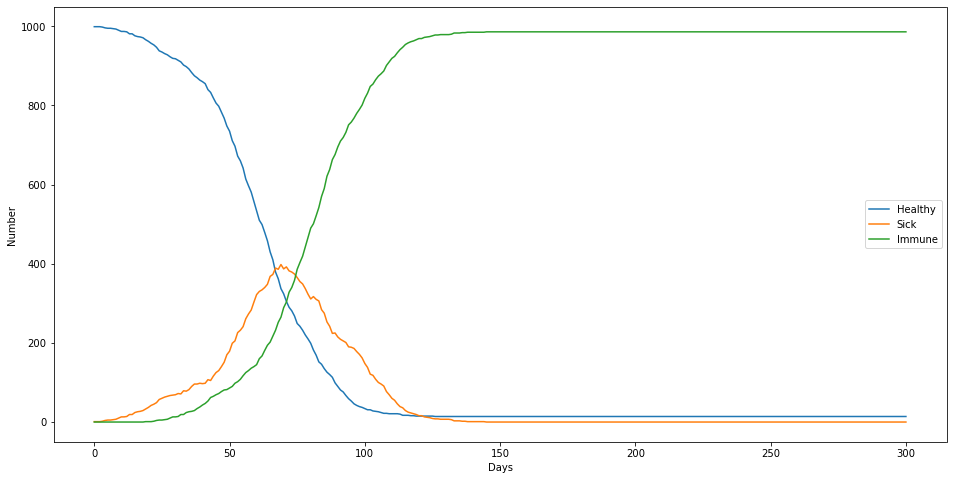

In [3]:
#Ok, everything works, now lets do some simulations

a = Simulation(1000,0.2,-50,50,-50,50,'Random_single_walk')
a.run(300)
results = a.get_results()
healthy = results['healthy']
sick = results['sick']
immune = results['immune']
plt.figure(figsize=(16, 8))
plt.plot(healthy,label='Healthy')
plt.plot(sick,label='Sick')
plt.plot(immune,label='Immune')
plt.xlabel('Days')
plt.ylabel('Number')
plt.legend()

In [4]:
#Lets do a run of 100 simulations 
a = Experiment(100,(1/5),1000,-50,50,-50,50)
# a.run_func_for_parallel(10,100)
a.run_forward_for_x_days(300)
result = a.get_results()

100%|██████████| 100/100 [11:52<00:00,  7.12s/it]


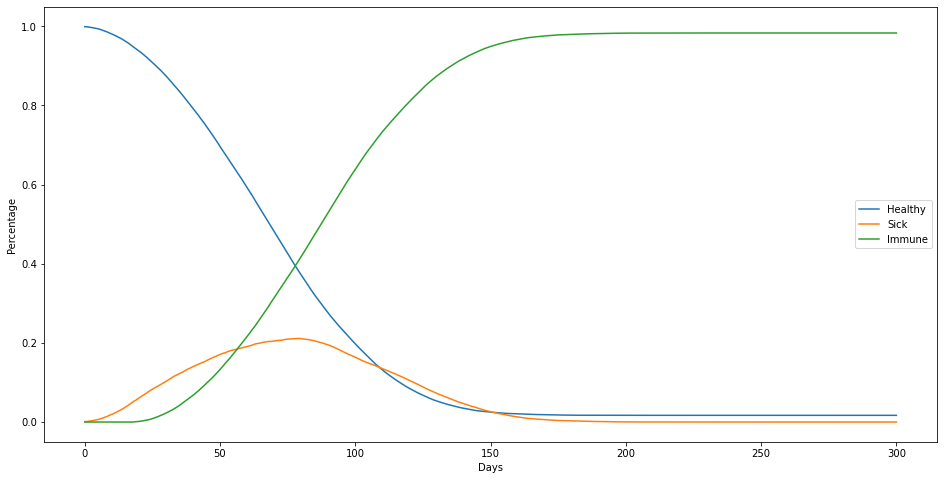

In [5]:
exp_N1000 = a
ave_results_1000 = exp_N1000.get_results_average()
plt.figure(figsize=(16, 8))
plt.plot(ave_results_1000['healthy'],label='Healthy')
plt.plot(ave_results_1000['sick'],label='Sick')
plt.plot(ave_results_1000['immune'],label='Immune')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()

In [6]:
dist_max_sick_1000 = exp_N1000.get_distribution_max_sick()/exp_N1000.get_N()
# print(exp_N1000.get_N())

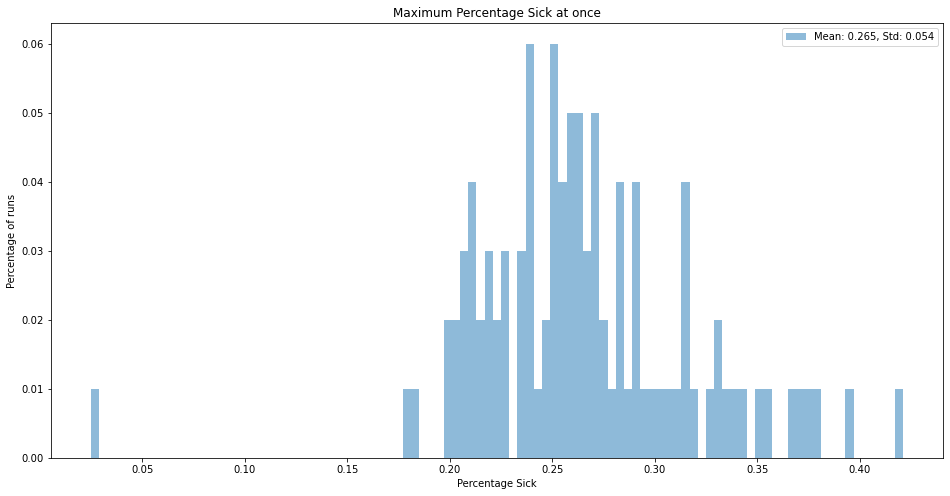

In [7]:
plt.figure(figsize=(16, 8))
plot_histogram(dist_max_sick_1000,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_max_sick_1000),3),np.round(np.std(dist_max_sick_1000),3)),np.amin(dist_max_sick_1000),np.amax(dist_max_sick_1000))
plt.title('Maximum Percentage Sick at once')
plt.xlabel('Percentage Sick')
plt.ylabel('Percentage of runs')
plt.legend()

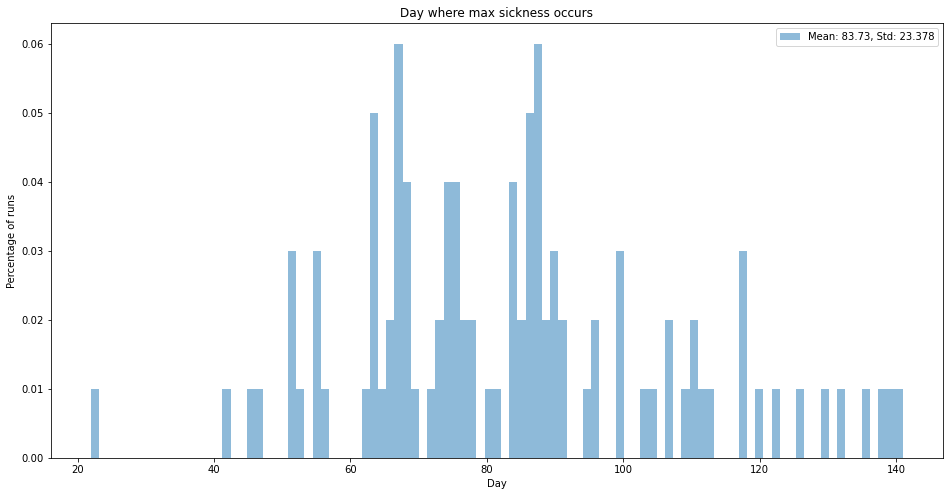

In [8]:
dist_day_max_sick_1000 = exp_N1000.get_distribution_max_sick_day()
plt.figure(figsize=(16, 8))
plot_histogram(dist_day_max_sick_1000,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_day_max_sick_1000),3),np.round(np.std(dist_day_max_sick_1000),3)),np.amin(dist_day_max_sick_1000),np.amax(dist_day_max_sick_1000))
plt.title('Day where max sickness occurs')
plt.xlabel('Day')
plt.ylabel('Percentage of runs')
plt.legend()

In [9]:
#Now lets try out simulations with larger N

exp_N2000 = Experiment(100,(1/5),2000,-50,50,-50,50)
# a.run_func_for_parallel(10,100)
exp_N2000.run_forward_for_x_days(300)
result = exp_N2000.get_results()

100%|██████████| 100/100 [37:19<00:00, 22.39s/it]


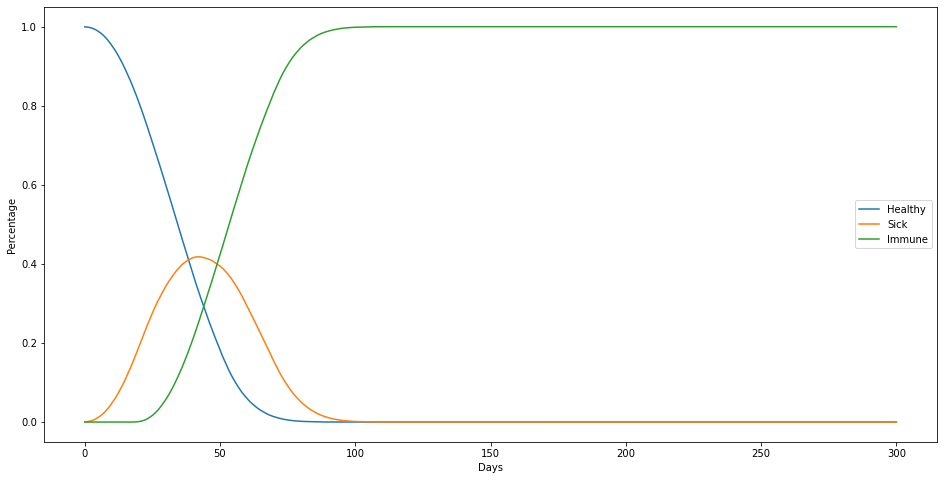

In [10]:
# exp_N1000 = a
ave_results_2000 = exp_N2000.get_results_average()
plt.figure(figsize=(16, 8))
plt.plot(ave_results_2000['healthy'],label='Healthy')
plt.plot(ave_results_2000['sick'],label='Sick')
plt.plot(ave_results_2000['immune'],label='Immune')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()

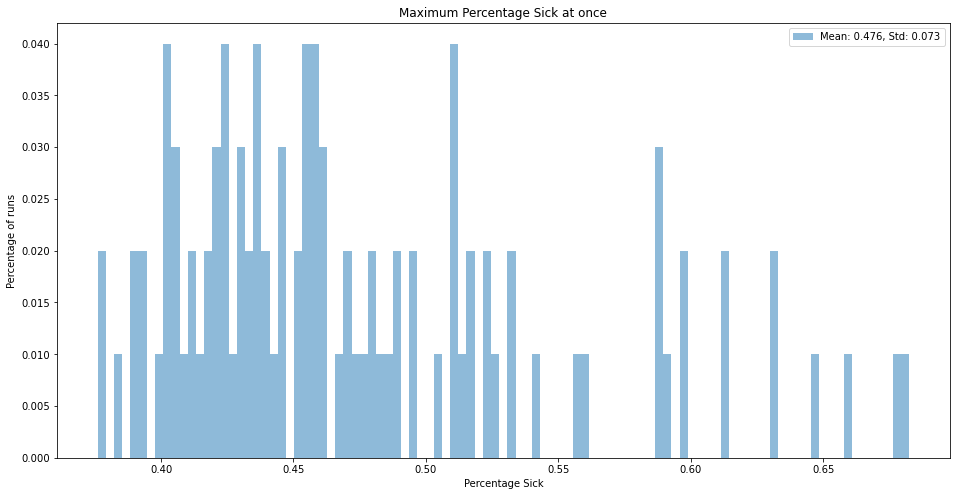

In [11]:
dist_max_sick_2000 = exp_N2000.get_distribution_max_sick()/exp_N2000.get_N()
plt.figure(figsize=(16, 8))
plot_histogram(dist_max_sick_2000,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_max_sick_2000),3),
                                                           np.round(np.std(dist_max_sick_2000),3)),np.amin(dist_max_sick_2000),np.amax(dist_max_sick_2000))
plt.title('Maximum Percentage Sick at once')
plt.xlabel('Percentage Sick')
plt.ylabel('Percentage of runs')
plt.legend()

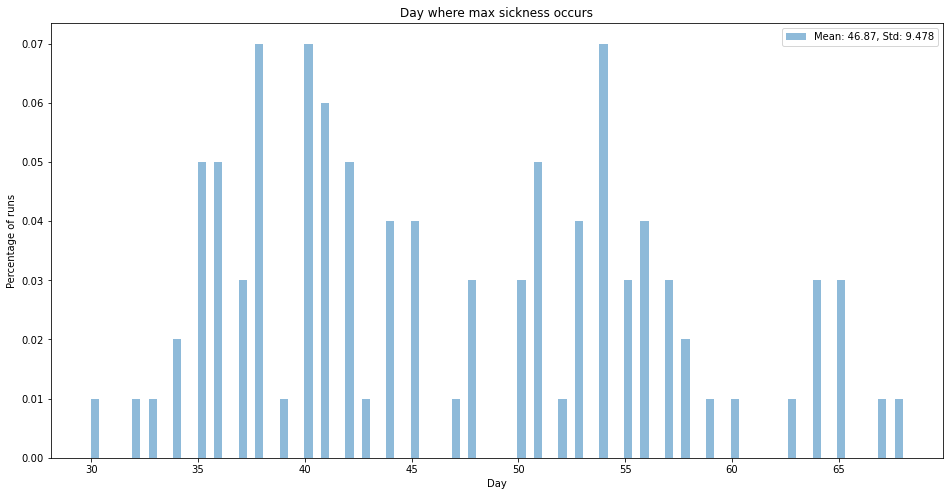

In [12]:
dist_day_max_sick_2000 = exp_N2000.get_distribution_max_sick_day()
plt.figure(figsize=(16, 8))
plot_histogram(dist_day_max_sick_2000,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_day_max_sick_2000),3),
                                                               np.round(np.std(dist_day_max_sick_2000),3)),np.amin(dist_day_max_sick_2000),np.amax(dist_day_max_sick_2000))
plt.title('Day where max sickness occurs')
plt.xlabel('Day')
plt.ylabel('Percentage of runs')
plt.legend()

In [13]:
#What if we go back to 1000 people, but people wear masks? So the base chance for infecting someone is lower (halved in this experiment)
exp_N1000_mask = Experiment(100,(0.1),1000,-50,50,-50,50)
exp_N1000_mask.run_forward_for_x_days(300)
# print(exp_N1000_mask.simulations[0])

100%|██████████| 100/100 [13:29<00:00,  8.10s/it]


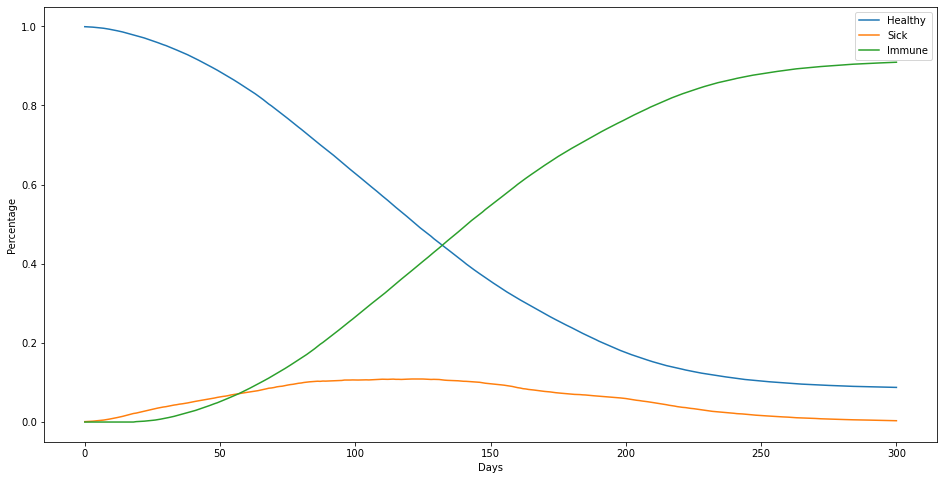

In [14]:
ave_results_1000_mask  = exp_N1000_mask.get_results_average()
plt.figure(figsize=(16, 8))
plt.plot(ave_results_1000_mask['healthy'],label='Healthy')
plt.plot(ave_results_1000_mask['sick'],label='Sick')
plt.plot(ave_results_1000_mask['immune'],label='Immune')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()

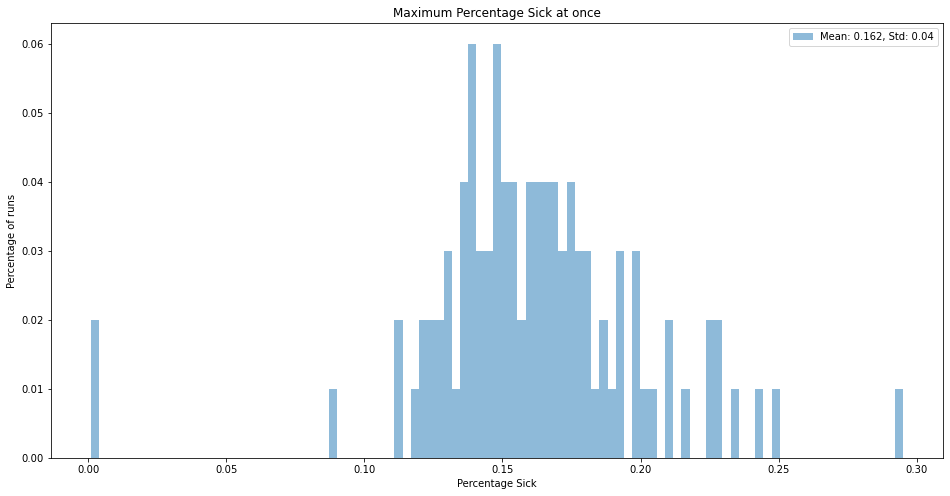

In [15]:
dist_max_sick_1000_mask = exp_N1000_mask.get_distribution_max_sick()/exp_N1000_mask.get_N()
plt.figure(figsize=(16, 8))
plot_histogram(dist_max_sick_1000_mask,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_max_sick_1000_mask),3),
                                                                np.round(np.std(dist_max_sick_1000_mask),3)),np.amin(dist_max_sick_1000_mask),
               np.amax(dist_max_sick_1000_mask))
plt.title('Maximum Percentage Sick at once')
plt.xlabel('Percentage Sick')
plt.ylabel('Percentage of runs')
plt.legend()

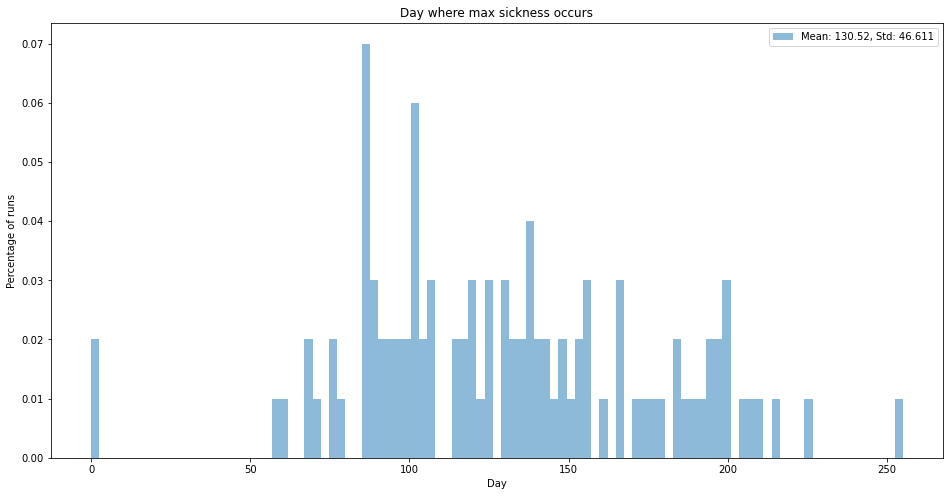

In [16]:
dist_day_max_sick_1000_mask = exp_N1000_mask.get_distribution_max_sick_day()
plt.figure(figsize=(16, 8))
plot_histogram(dist_day_max_sick_1000_mask,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_day_max_sick_1000_mask),3),
                                                                    np.round(np.std(dist_day_max_sick_1000_mask),3)),np.amin(dist_day_max_sick_1000_mask),
               np.amax(dist_day_max_sick_1000_mask))
plt.title('Day where max sickness occurs')
plt.xlabel('Day')
plt.ylabel('Percentage of runs')
plt.legend()

In [17]:
#What if we go back to 1000 people with no mask, but sick people are not allowed to walk?
exp_N1000_sickstationary = Experiment(100,(0.2),1000,-50,50,-50,50,walk_method = 'Sick_become_stationary')
exp_N1000_sickstationary.run_forward_for_x_days(300)
# print(exp_N1000_mask.simulations[0])

100%|██████████| 100/100 [12:14<00:00,  7.34s/it]


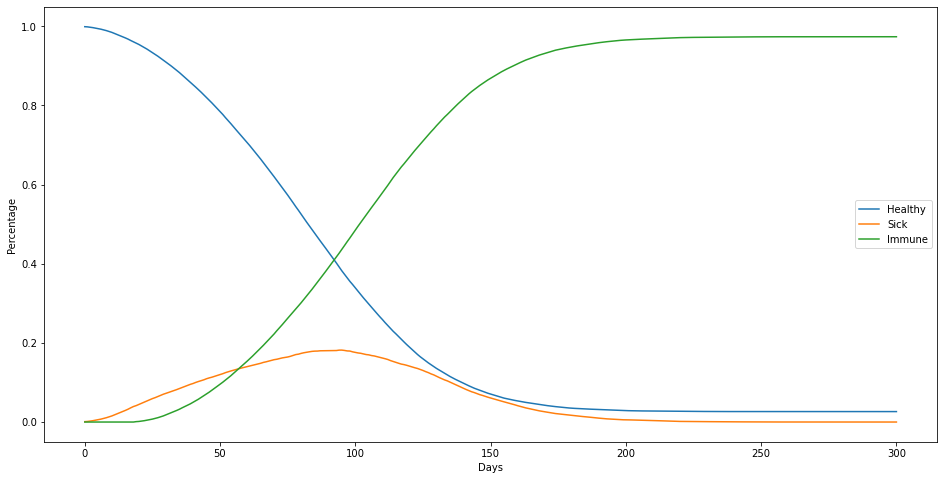

In [18]:
ave_results_1000_sickstationary  = exp_N1000_sickstationary.get_results_average()
plt.figure(figsize=(16, 8))
plt.plot(ave_results_1000_sickstationary['healthy'],label='Healthy')
plt.plot(ave_results_1000_sickstationary['sick'],label='Sick')
plt.plot(ave_results_1000_sickstationary['immune'],label='Immune')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()

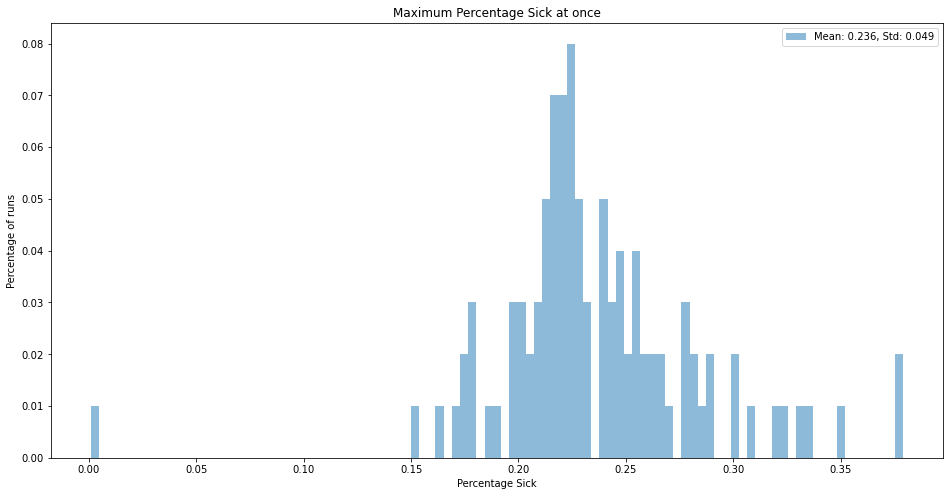

In [19]:
dist_max_sick_1000_sickstationary = exp_N1000_sickstationary.get_distribution_max_sick()/exp_N1000_sickstationary.get_N()
plt.figure(figsize=(16, 8))
plot_histogram(dist_max_sick_1000_sickstationary,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_max_sick_1000_sickstationary),3),
                                                                np.round(np.std(dist_max_sick_1000_sickstationary),3)),np.amin(dist_max_sick_1000_sickstationary),
               np.amax(dist_max_sick_1000_sickstationary))
plt.title('Maximum Percentage Sick at once')
plt.xlabel('Percentage Sick')
plt.ylabel('Percentage of runs')
plt.legend()

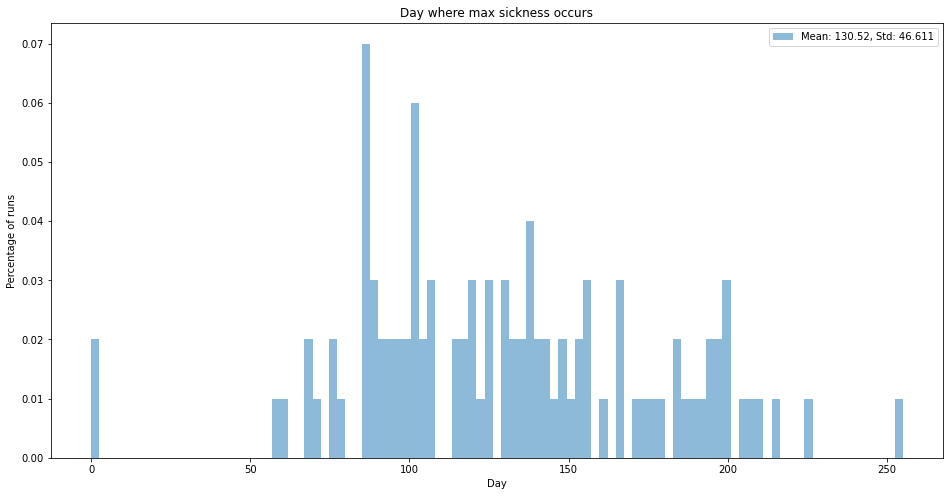

In [20]:
dist_day_max_sick_1000_sickstationary = exp_N1000_mask.get_distribution_max_sick_day()
plt.figure(figsize=(16, 8))
plot_histogram(dist_day_max_sick_1000_mask,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_day_max_sick_1000_mask),3),
                                                                    np.round(np.std(dist_day_max_sick_1000_mask),3)),np.amin(dist_day_max_sick_1000_mask),
               np.amax(dist_day_max_sick_1000_mask))
plt.title('Day where max sickness occurs')
plt.xlabel('Day')
plt.ylabel('Percentage of runs')
plt.legend()

In [4]:
#Now, let us examine the results over a range of N, to see if there is any density phase transition.
Ns = np.round(np.logspace(5,11,num=20,base=2))
all_N_experiments_more = []
for i in Ns:
    thisN = int(i)
    print('Doing N = %s now'%(thisN))
    a = Experiment(100,(1/5),thisN,-50,50,-50,50,walk_method='Random_single_walk')
    # a.run_func_for_parallel(10,100)
    a.run_forward_for_x_days(300)
    all_N_experiments_more.append(a)

Doing N = 32 now


100%|██████████| 100/100 [00:00<00:00, 169.10it/s]


Doing N = 40 now


100%|██████████| 100/100 [00:00<00:00, 392.33it/s]


Doing N = 50 now


100%|██████████| 100/100 [00:00<00:00, 344.62it/s]


Doing N = 62 now


100%|██████████| 100/100 [00:00<00:00, 268.81it/s]


Doing N = 77 now


100%|██████████| 100/100 [00:00<00:00, 132.56it/s]


Doing N = 96 now


100%|██████████| 100/100 [00:00<00:00, 108.28it/s]


Doing N = 119 now


100%|██████████| 100/100 [00:01<00:00, 84.81it/s]


Doing N = 148 now


100%|██████████| 100/100 [00:01<00:00, 66.99it/s]


Doing N = 184 now


100%|██████████| 100/100 [00:01<00:00, 54.03it/s]


Doing N = 229 now


100%|██████████| 100/100 [00:03<00:00, 30.33it/s]


Doing N = 286 now


100%|██████████| 100/100 [00:04<00:00, 20.67it/s]


Doing N = 355 now


100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


Doing N = 442 now


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Doing N = 551 now


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Doing N = 686 now


100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Doing N = 853 now


100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


Doing N = 1062 now


100%|██████████| 100/100 [06:00<00:00,  3.60s/it]


Doing N = 1322 now


100%|██████████| 100/100 [08:34<00:00,  5.15s/it]


Doing N = 1645 now


100%|██████████| 100/100 [12:22<00:00,  7.43s/it]


Doing N = 2048 now


100%|██████████| 100/100 [17:51<00:00, 10.72s/it]


Text(0, 0.5, 'Ending Percentage')

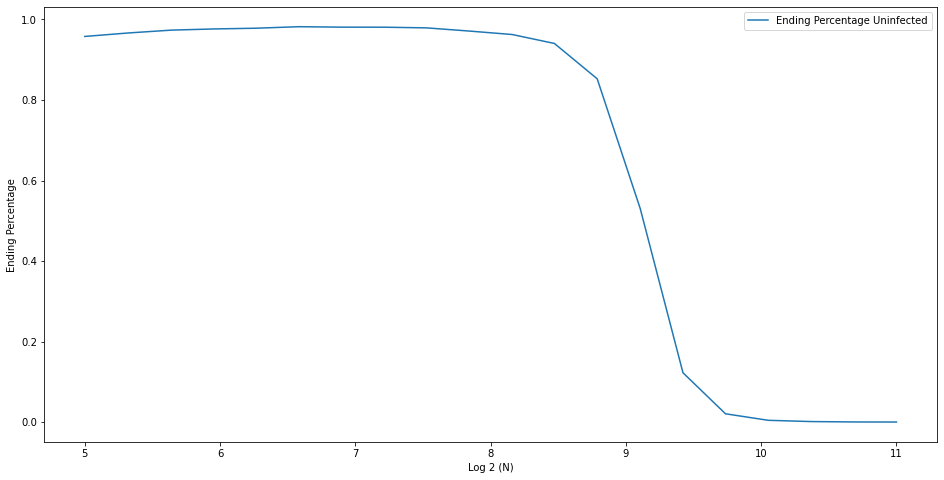

In [5]:
ending_percentage_healthy = []
ending_percentage_immune = []
for b in all_N_experiments_more:
    ending_percentage_healthy.append(b.get_results_average()['healthy'][-1])
    ending_percentage_immune.append(b.get_results_average()['immune'][-1])
plt.figure(figsize=(16, 8))
plt.plot(np.log2(Ns),ending_percentage_healthy,label='Ending Percentage Uninfected')
# plt.plot(np.log2(Ns),ending_percentage_healthy,label='Ending Percentage Uninfected')
plt.xlabel('Log 2 (N)')
plt.legend()
plt.ylabel('Ending Percentage')

Text(0, 0.5, 'Maximum Percentage')

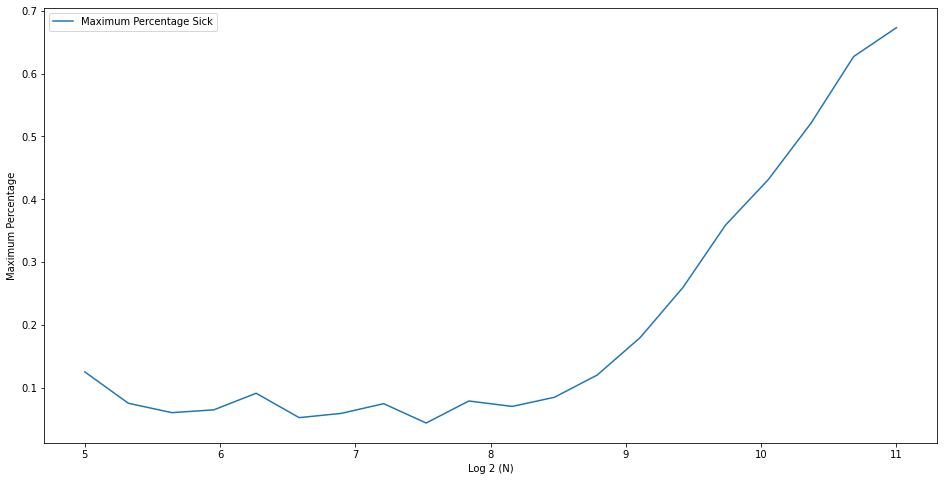

In [8]:
max_percentage_sickness = []
for b in all_N_experiments_more:
    max_percentage_sickness.append(np.max(b.get_distribution_max_sick()/b.get_N()))
plt.figure(figsize=(16, 8))
plt.plot(np.log2(Ns),max_percentage_sickness,label='Maximum Percentage Sick')
# plt.plot(np.log2(Ns),ending_percentage_healthy,label='Ending Percentage Uninfected')
plt.xlabel('Log 2 (N)')
plt.legend()
plt.ylabel('Maximum Percentage')

In [6]:
#Perform same experiments but for wearing mask
Ns = np.round(np.logspace(5,11,num=20,base=2))
all_N_experiments_mask_more = []
for i in Ns:
    thisN = int(i)
    print('Doing N = %s now'%(thisN))
    a = Experiment(100,(0.1),thisN,-50,50,-50,50,walk_method='Random_single_walk')
    # a.run_func_for_parallel(10,100)
    a.run_forward_for_x_days(300)
    all_N_experiments_mask_more.append(a)

Doing N = 32 now


100%|██████████| 100/100 [00:00<00:00, 495.94it/s]


Doing N = 40 now


100%|██████████| 100/100 [00:00<00:00, 402.97it/s]


Doing N = 50 now


100%|██████████| 100/100 [00:00<00:00, 328.46it/s]


Doing N = 62 now


100%|██████████| 100/100 [00:00<00:00, 278.91it/s]


Doing N = 77 now


100%|██████████| 100/100 [00:00<00:00, 136.36it/s]


Doing N = 96 now


100%|██████████| 100/100 [00:00<00:00, 108.50it/s]


Doing N = 119 now


100%|██████████| 100/100 [00:01<00:00, 87.61it/s]


Doing N = 148 now


100%|██████████| 100/100 [00:01<00:00, 72.35it/s]


Doing N = 184 now


100%|██████████| 100/100 [00:01<00:00, 56.04it/s]


Doing N = 229 now


100%|██████████| 100/100 [00:02<00:00, 36.14it/s]


Doing N = 286 now


100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Doing N = 355 now


100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


Doing N = 442 now


100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


Doing N = 551 now


100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Doing N = 686 now


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Doing N = 853 now


100%|██████████| 100/100 [03:48<00:00,  2.28s/it]


Doing N = 1062 now


100%|██████████| 100/100 [06:37<00:00,  3.97s/it]


Doing N = 1322 now


100%|██████████| 100/100 [09:55<00:00,  5.96s/it]


Doing N = 1645 now


100%|██████████| 100/100 [14:17<00:00,  8.58s/it]


Doing N = 2048 now


100%|██████████| 100/100 [20:45<00:00, 12.46s/it]


Text(0, 0.5, 'Ending Percentage')

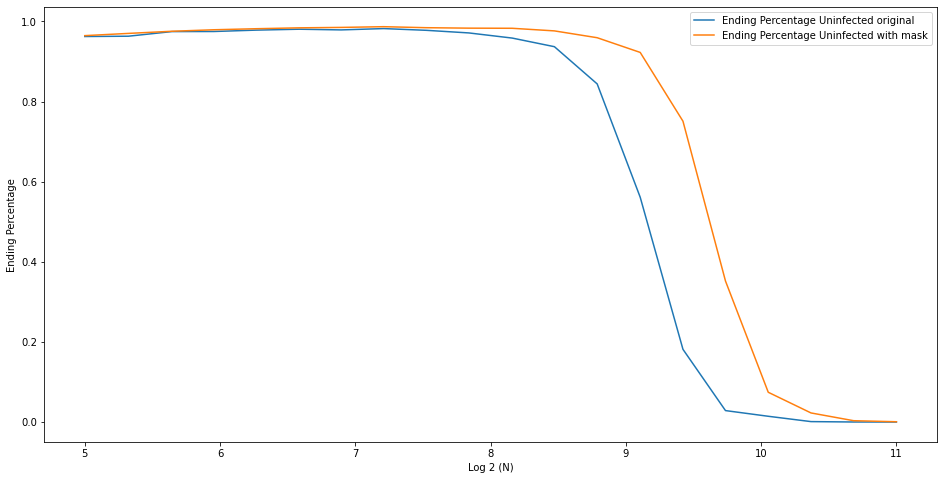

In [59]:
ending_percentage_healthy_mask = []
ending_percentage_immune_mask = []
for b in all_N_experiments_mask_more:
    ending_percentage_healthy_mask.append(b.get_results_average()['healthy'][-1])
    ending_percentage_immune_mask.append(b.get_results_average()['immune'][-1])
plt.figure(figsize=(16, 8))
plt.plot(np.log2(Ns),ending_percentage_healthy,label='Ending Percentage Uninfected original')
plt.plot(np.log2(Ns),ending_percentage_healthy_mask,label='Ending Percentage Uninfected with mask')
# plt.plot(np.log2(Ns),ending_percentage_healthy,label='Ending Percentage Uninfected')
plt.xlabel('Log 2 (N)')
plt.legend()
plt.ylabel('Ending Percentage')

Text(0, 0.5, 'Maximum Percentage')

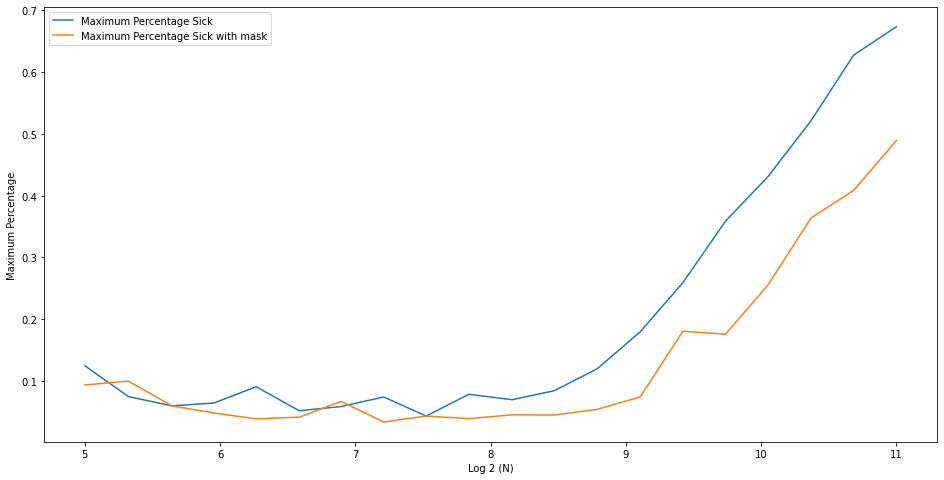

In [9]:
max_percentage_sickness_mask = []
for b in all_N_experiments_mask_more:
    max_percentage_sickness_mask.append(np.max(b.get_distribution_max_sick()/b.get_N()))
plt.figure(figsize=(16, 8))
plt.plot(np.log2(Ns),max_percentage_sickness,label='Maximum Percentage Sick')
plt.plot(np.log2(Ns),max_percentage_sickness_mask,label='Maximum Percentage Sick with mask')
# plt.plot(np.log2(Ns),ending_percentage_healthy,label='Ending Percentage Uninfected')
plt.xlabel('Log 2 (N)')
plt.legend()
plt.ylabel('Maximum Percentage')

In [3]:
#Let us attempt to construct an ENTIRE phase diagram over N and chance to infect
Ns = np.round(np.logspace(5,11,num=10,base=2))
chances = np.linspace(0,0.5,num=10)
phase_diag_experiments = []
for i in Ns:
    thisN = int(i)
    thisNexperiments = []
    for c in chances:
        thischance = c
        print('Doing N = %s, Chance = %s now'%(thisN,thischance))
        a = Experiment(50,thischance,thisN,-50,50,-50,50,walk_method='Random_single_walk')
        # a.run_func_for_parallel(10,100)
        a.run_forward_for_x_days(300)
        thisNexperiments.append(a)
    phase_diag_experiments.append(thisNexperiments)

  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 32, Chance = 0.0 now


100%|██████████| 50/50 [00:00<00:00, 297.35it/s]


Doing N = 32, Chance = 0.05555555555555555 now


100%|██████████| 50/50 [00:00<00:00, 310.28it/s]

Doing N = 32, Chance = 0.1111111111111111 now



100%|██████████| 50/50 [00:00<00:00, 304.60it/s]

Doing N = 32, Chance = 0.16666666666666666 now



100%|██████████| 50/50 [00:00<00:00, 275.99it/s]

Doing N = 32, Chance = 0.2222222222222222 now



100%|██████████| 50/50 [00:00<00:00, 310.28it/s]

Doing N = 32, Chance = 0.2777777777777778 now



100%|██████████| 50/50 [00:00<00:00, 304.60it/s]

Doing N = 32, Chance = 0.3333333333333333 now



100%|██████████| 50/50 [00:00<00:00, 293.85it/s]

Doing N = 32, Chance = 0.38888888888888884 now



100%|██████████| 50/50 [00:00<00:00, 308.36it/s]

Doing N = 32, Chance = 0.4444444444444444 now



100%|██████████| 50/50 [00:00<00:00, 299.13it/s]

Doing N = 32, Chance = 0.5 now



 48%|████▊     | 24/50 [00:00<00:00, 219.98it/s]

Doing N = 51, Chance = 0.0 now


 48%|████▊     | 24/50 [00:00<00:00, 219.98it/s]

Doing N = 51, Chance = 0.05555555555555555 now


 48%|████▊     | 24/50 [00:00<00:00, 216.02it/s]

Doing N = 51, Chance = 0.1111111111111111 now


 48%|████▊     | 24/50 [00:00<00:00, 230.56it/s]

Doing N = 51, Chance = 0.16666666666666666 now


 48%|████▊     | 24/50 [00:00<00:00, 217.98it/s]

Doing N = 51, Chance = 0.2222222222222222 now


 48%|████▊     | 24/50 [00:00<00:00, 212.20it/s]

Doing N = 51, Chance = 0.2777777777777778 now


 48%|████▊     | 24/50 [00:00<00:00, 203.21it/s]

Doing N = 51, Chance = 0.3333333333333333 now


 48%|████▊     | 24/50 [00:00<00:00, 216.06it/s]

Doing N = 51, Chance = 0.38888888888888884 now


 48%|████▊     | 24/50 [00:00<00:00, 217.98it/s]

Doing N = 51, Chance = 0.4444444444444444 now


 48%|████▊     | 24/50 [00:00<00:00, 222.02it/s]

Doing N = 51, Chance = 0.5 now


 48%|████▊     | 24/50 [00:00<00:00, 141.88it/s]

Doing N = 81, Chance = 0.0 now


 48%|████▊     | 24/50 [00:00<00:00, 146.21it/s]

Doing N = 81, Chance = 0.05555555555555555 now


 48%|████▊     | 24/50 [00:00<00:00, 142.73it/s]

Doing N = 81, Chance = 0.1111111111111111 now


 48%|████▊     | 24/50 [00:00<00:00, 141.05it/s]

Doing N = 81, Chance = 0.16666666666666666 now


 48%|████▊     | 24/50 [00:00<00:00, 141.88it/s]

Doing N = 81, Chance = 0.2222222222222222 now


 48%|████▊     | 24/50 [00:00<00:00, 134.33it/s]

Doing N = 81, Chance = 0.2777777777777778 now


 48%|████▊     | 24/50 [00:00<00:00, 140.63it/s]

Doing N = 81, Chance = 0.3333333333333333 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 81, Chance = 0.38888888888888884 now


 48%|████▊     | 24/50 [00:00<00:00, 144.07it/s]

Doing N = 81, Chance = 0.4444444444444444 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 81, Chance = 0.5 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.0 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.05555555555555555 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.1111111111111111 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.16666666666666666 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.2222222222222222 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.2777777777777778 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.3333333333333333 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.38888888888888884 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.4444444444444444 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 128, Chance = 0.5 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.0 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.05555555555555555 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.1111111111111111 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.16666666666666666 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.2222222222222222 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.2777777777777778 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.3333333333333333 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.38888888888888884 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.4444444444444444 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 203, Chance = 0.5 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.0 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.05555555555555555 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.1111111111111111 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.16666666666666666 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.2222222222222222 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.2777777777777778 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.3333333333333333 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.38888888888888884 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.4444444444444444 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 323, Chance = 0.5 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.0 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.05555555555555555 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.1111111111111111 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.16666666666666666 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.2222222222222222 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.2777777777777778 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.3333333333333333 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.38888888888888884 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.4444444444444444 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 512, Chance = 0.5 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.0 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.05555555555555555 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.1111111111111111 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.16666666666666666 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.2222222222222222 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.2777777777777778 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.3333333333333333 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.38888888888888884 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.4444444444444444 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 813, Chance = 0.5 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.0 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.05555555555555555 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.1111111111111111 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.16666666666666666 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.2222222222222222 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.2777777777777778 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.3333333333333333 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.38888888888888884 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.4444444444444444 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 1290, Chance = 0.5 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.0 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.05555555555555555 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.1111111111111111 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.16666666666666666 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.2222222222222222 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.2777777777777778 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.3333333333333333 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.38888888888888884 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.4444444444444444 now


  0%|          | 0/50 [00:00<?, ?it/s]

Doing N = 2048, Chance = 0.5 now


100%|██████████| 50/50 [06:22<00:00,  7.65s/it]


In [5]:
heatmap = []
for i in range(len(Ns)):
    thisheatmaprow = []
    for c in range(len(chances)):
        thisheatmaprow.append(phase_diag_experiments[i][c].get_results_average()['healthy'][-1])
    heatmap.append(thisheatmaprow)

Text(0.5, 1.0, 'Percentage healthy at end')

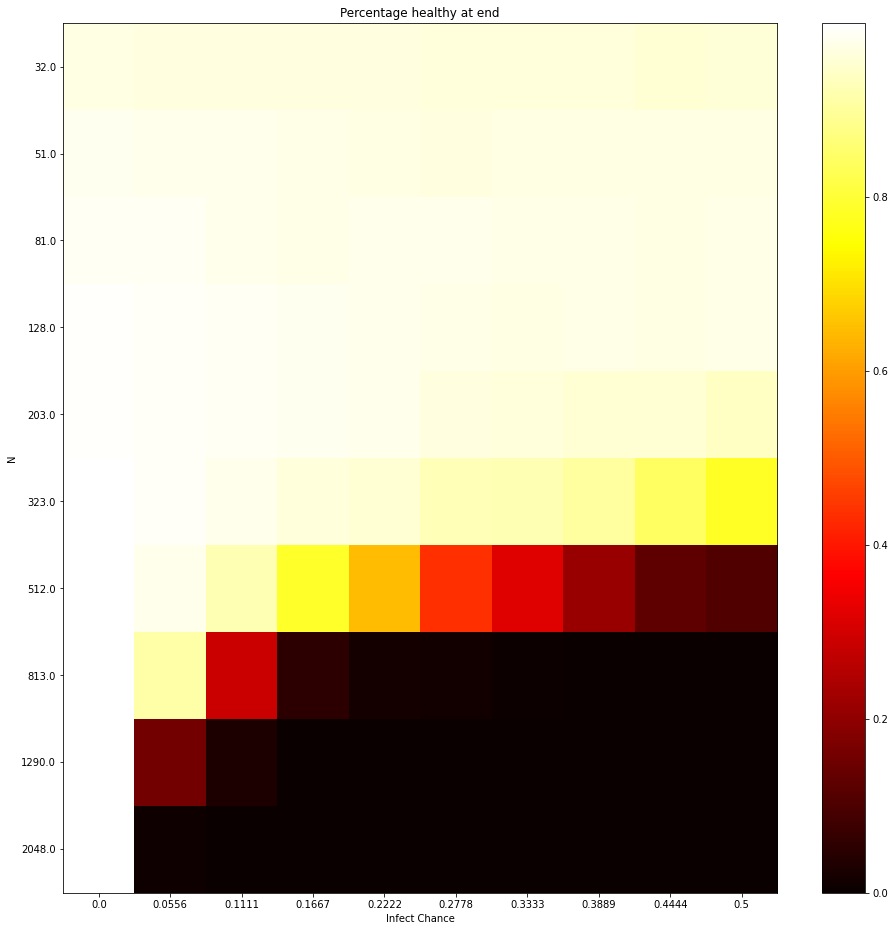

: 

In [17]:
heatmap = np.array(heatmap)
fig, ax = plt.subplots(figsize=(16, 16))
img = ax.imshow(heatmap,cmap='hot')
ax.set_aspect("auto")
xlength = len(heatmap[0])
plt.yticks(np.linspace(0,xlength-1,num=10,endpoint=True),np.array(Ns))
ylength = len(heatmap)
plt.xticks(np.linspace(0,ylength-1,num=10,endpoint=True),np.round(np.array(chances),4))
plt.colorbar(img)
plt.xlabel('Infect Chance')
plt.ylabel('N')
plt.title('Percentage healthy at end') 